# Distributed Training Demo: Fine tuning a pre-trained Hugging Face model with SageMaker for question answering

### Distributed Data Parallel Training  with using `SageMakerTrainer` combined with Hugging Face pre-trained models on `squad` dataset

1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
    1. [Installation](#Installation)  
    2. [Development environment](#Development-environment)  
    3. [Permissions](#Permissions) 
4. [Fine-tuning & starting Sagemaker Training Job](#Fine-tuning-\&-starting-Sagemaker-Training-Job)  
    1. [Creating an Estimator and start a training job](#Creating-an-Estimator-and-start-a-training-job)  
    2. [Estimator Parameters](#Estimator-Parameters)   
    3. [Download fine-tuned model from s3](#Download-fine-tuned-model-from-s3)
    3. [Attach to old training job to an estimator ](#Attach-to-old-training-job-to-an-estimator)  
5. [_Coming soon_:Push model to the Hugging Face hub](#Push-model-to-the-Hugging-Face-hub)

# Introduction

Welcome to our end-to-end `distributed` Question-Answering example. In this demo, we will use the Hugging Face `transformers` and `datasets` library together with a custom Amazon sagemaker-sdk extension to fine-tune a pre-trained transformer for question-answering on multiple-gpus. In particular, the pre-trained model will be fine-tuned using the `squad` dataset. The demo will use the new `smdistributed` library to run training on multiple gpus as training scripting we are going to use one of the `transformers` [example scripts from the repository](https://github.com/huggingface/transformers/blob/master/examples/question-answering/run_qa.py).

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

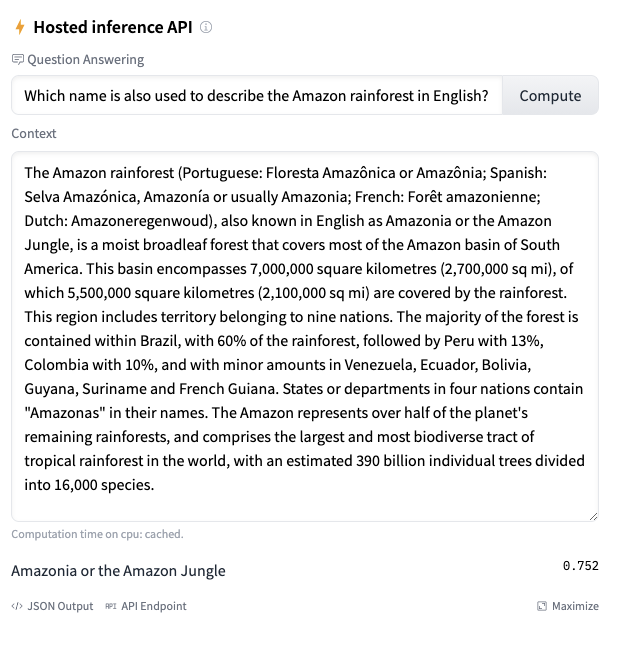


_**NOTE: You can run this demo in Sagemaker Studio, your local machine or Sagemaker Notebook Instances**_

# Development Environment and Permissions 

## Installation

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow, if you haven´t it installed_

In [ ]:
#!pip install "sagemaker>=2.48.0" "transformers==4.6.1" "datasets[s3]==1.6.2" accelerate --upgrade

## Development environment 

**upgrade ipywidgets for `datasets` library and restart kernel, only needed when prerpocessing is done in the notebook**

In [ ]:
%%capture
import IPython
#!conda install -c conda-forge ipywidgets -y
#IPython.Application.instance().kernel.do_shutdown(True) # has to restart kernel so changes are used

In [1]:
import sagemaker.huggingface
import logging
import transformers

logger = logging.getLogger('__name__')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())
logger.info(f'Using SageMaker version: {sagemaker.__version__}')
logger.info(f'Using Transfomer version: {transformers.__version__}')

Using SageMaker version: 2.96.0
Using Transfomer version: 4.19.2


## Permissions

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [2]:
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

#role = sagemaker.get_execution_role()
role = 'arn:aws:iam::976939723775:role/service-role/AmazonSageMaker-ExecutionRole-20210317T133000'
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::976939723775:role/service-role/AmazonSageMaker-ExecutionRole-20210317T133000
sagemaker bucket: sagemaker-us-west-2-976939723775
sagemaker session region: us-west-2


# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job we need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator we define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in .....



```python
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            sagemaker_session=sess,
                            base_job_name='huggingface-sdk-extension',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            transformers_version='4.4',
                            pytorch_version='1.6.0',
                            py_version='py36',
                            role=role,
                            hyperparameters = {'epochs': 1,
                                               'train_batch_size': 32,
                                               'model_name':'distilbert-base-uncased'
                                                })
```

When we create a SageMaker training job, SageMaker takes care of starting and managing all the required ec2 instances for us with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container at `/opt/ml/input/data`. Then, it starts the training job by running. 

```python
/opt/conda/bin/python train.py --epochs 1 --model_name distilbert-base-uncased --train_batch_size 32
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. 

Sagemaker is providing useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.


To run your training job locally you can define `instance_type='local'` or `instance_type='local_gpu'` for gpu usage. _Note: this does not working within SageMaker Studio_


## Creating an Estimator and start a training job

In this example we are going to use the capability to download/use a fine-tuning script from a `git`- repository. We are using the `run_qa.py` from the `transformers` example scripts. You can find the code [here](https://github.com/huggingface/transformers/tree/master/examples/question-answering).


### RANK in MPI

As to your question: processes are the actual instances of the program that are running. MPI allows you to create logical groups of processes, and in each group, a process is identified by its rank. This is an integer in the range [0, N-1] where N is the size of the group. Communicators are objects that handle communication between processes. An intra-communicator handles processes within a single group, while an inter-communicator handles communication between two distinct groups.

By default, you have a single group that contains all your processes, and the intra-communicator MPI_COMM_WORLD that handles communication between them. This is sufficient for most applications, and does blur the distinction between process and rank a bit. The main thing to remember is that the rank of a process is always relative to a group. If you were to split your processes into two groups (e.g. one group to read input and another group to process data), then each process would now have two ranks: the one it originally had in MPI_COMM_WORLD, and one in its new group.

In [3]:
from transformers import AutoTokenizer

# tokenizer used in preprocessing
tokenizer_name = 'bert-large-uncased-whole-word-masking'
#tokenizer_name = 'roberta-large'

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

In [4]:
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={
    'model_name_or_path': tokenizer_name,
    'dataset_name':'squad',
    'do_train': True,
    'do_eval': True,
    'fp16': True,
    'per_device_train_batch_size': 4,
    'per_device_eval_batch_size': 4,
    'num_train_epochs': 2,
    'max_seq_length': 384,
    'max_steps': 100,
    'pad_to_max_length': True,
    'doc_stride': 128,
    'output_dir': '/opt/ml/model',
}


# configuration for running training on smdistributed Data Parallel
dp_options = {
    "enabled":True,
    "custom_mpi_options": "-verbose -x NCCL_DEBUG=VERSION -x RANK=0 -x WORLD_SIZE=16",
    "parameters": {
        "microbatches": 4,
    }
}

# configuration for running training on smdistributed Data Parallel
distribution = {
    'smdistributed':{'dataparallel':dp_options}, 
    'parameter_server':{'enabled':False},
}


# git configuration to download our fine-tuning script
git_config = {'repo': 'https://github.com/huggingface/transformers.git','branch': 'v4.6.1'}
hub = {
    'HF_MODEL_ID':tokenizer_name,
    'SAGEMAKER_REQUIREMENTS': 'glue_requirements.txt', # path relative to `source_dir` below.
    'HF_TASK':'question-answering'
}
# instance configurations
instance_type='ml.p3.16xlarge'
instance_count=2 # if set 1 you might get "Environment variable SAGEMAKER_INSTANCE_TYPE is not set" error
volume_size=200


# metric definition to extract the results
metric_definitions=[
     {"Name": "train_runtime", "Regex": "train_runtime.*=\D*(.*?)$"},
     {'Name': 'train_samples_per_second', 'Regex': "train_samples_per_second.*=\D*(.*?)$"},
     {'Name': 'epoch', 'Regex': "epoch.*=\D*(.*?)$"},
     {'Name': 'f1', 'Regex': "f1.*=\D*(.*?)$"},
     {'Name': 'exact_match', 'Regex': "exact_match.*=\D*(.*?)$"}]

In [5]:
# estimator
huggingface_estimator = HuggingFace(entry_point='run_qa.py',
                                    source_dir='./scripts/',
                                    #git_config=git_config,
                                    env=hub,
                                    metric_definitions=metric_definitions,
                                    instance_type=instance_type,
                                    instance_count=instance_count,
                                    volume_size=volume_size,
                                    role=role,
                                    transformers_version='4.17',
                                    pytorch_version='1.10',
                                    py_version='py38',
                                    distribution= distribution,
                                    hyperparameters = hyperparameters)

In [6]:
# starting the train job
huggingface_estimator.fit()

2022-07-06 23:05:10 Starting - Starting the training job...ProfilerReport-1657148710: InProgress
...
2022-07-06 23:06:04 Starting - Preparing the instances for training.........
2022-07-06 23:07:34 Downloading - Downloading input data...
2022-07-06 23:08:02 Training - Downloading the training image.....................
2022-07-06 23:11:41 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.8/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
2022-07-06 23:11:44,621 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-06 23:11:44,694 sagemaker_pytorch_container.training INFO     Block until all host D

In [36]:
huggingface_estimator.latest_training_job.name

'huggingface-pytorch-training-2022-06-03-21-36-30-007'

## Deploying the endpoint

To deploy our endpoint, we call `deploy()` on our HuggingFace estimator object, passing in our desired number of instances and instance type.

In [37]:
predictor = huggingface_estimator.deploy(1,"ml.m4.2xlarge")

------!

Then, we use the returned predictor object to call the endpoint.

In [40]:
data = {
"inputs": {
	#"question": "What is used for inference?",
    "question": "What does Philipp live?",
	"context": "My Name is Philipp and I live in Nuremberg. This model is used with sagemaker for inference."
	}
}
predictor.predict(data)

{'score': 0.950797975063324, 'start': 33, 'end': 42, 'answer': 'Nuremberg'}

Finally, we delete the endpoint again.

In [47]:
predictor.delete_endpoint()

## Display HF Estimator parameters and artifacts (Optional)

In [41]:
# container image used for training job
print(f"container image used for training job: \n{huggingface_estimator.image_uri}\n")

# s3 uri where the trained model is located
print(f"s3 uri where the trained model is located: \n{huggingface_estimator.model_data}\n")

# latest training job name for this estimator
print(f"latest training job name for this estimator: \n{huggingface_estimator.latest_training_job.name}\n")



container image used for training job: 
None

s3 uri where the trained model is located: 
s3://sagemaker-us-west-2-976939723775/huggingface-pytorch-training-2022-06-03-21-36-30-007/output/model.tar.gz

latest training job name for this estimator: 
huggingface-pytorch-training-2022-06-03-21-36-30-007



In [42]:
# access the logs of the training job
huggingface_estimator.sagemaker_session.logs_for_job(huggingface_estimator.latest_training_job.name)

2022-06-03 21:54:18 Starting - Preparing the instances for training
2022-06-03 21:54:18 Downloading - Downloading input data
2022-06-03 21:54:18 Training - Training image download completed. Training in progress.
2022-06-03 21:54:18 Uploading - Uploading generated training model
2022-06-03 21:54:18 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.8/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
2022-06-03 21:43:50,796 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-06-03 21:43:50,868 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-06-03 21:43:50,875 sagemaker_pytorch_container.training INFO     Invoking SMDataParallel
2022-06-03 21:43:50,875 sagemaker_pytorch_container.training INFO     Inv

## Attach to old training job to an estimator (Optional)

In Sagemaker you can attach an old training job to an estimator to continue training, get results etc..

In [45]:
from sagemaker.estimator import Estimator

# job which is going to be attached to the estimator
old_training_job_name='<my-old-ddp-job>'

In [ ]:
# attach old training job
huggingface_estimator_loaded = Estimator.attach(old_training_job_name)

# get model output s3 from training job
huggingface_estimator_loaded.model_data